For data, see:
https://www.kaggle.com/vetrirah/ml-iot?select=train_ML_IOT.csv

In [23]:
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', 
       titlepad=10)
plt.rc('animation', html='html5')
plt.rc('figure', figsize=(20.0, 15.0))

font = {'size'   : 30}
plt.rc('font', **font)

df = pd.read_csv('train_ML_IOT.csv')

df.head()

DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041

Meaning of data in each column:
DateTime: the datetime on which the datapoint is sampled.
Junction: the junction index at which the traffic is numbered
Vehicles: number of vehicles passing the junction in 1 hr.
ID: identifier of the datapoint.

Check how many junctions are there.

In [2]:
df['Junction'].unique()

array([1, 2, 3, 4], dtype=int64)

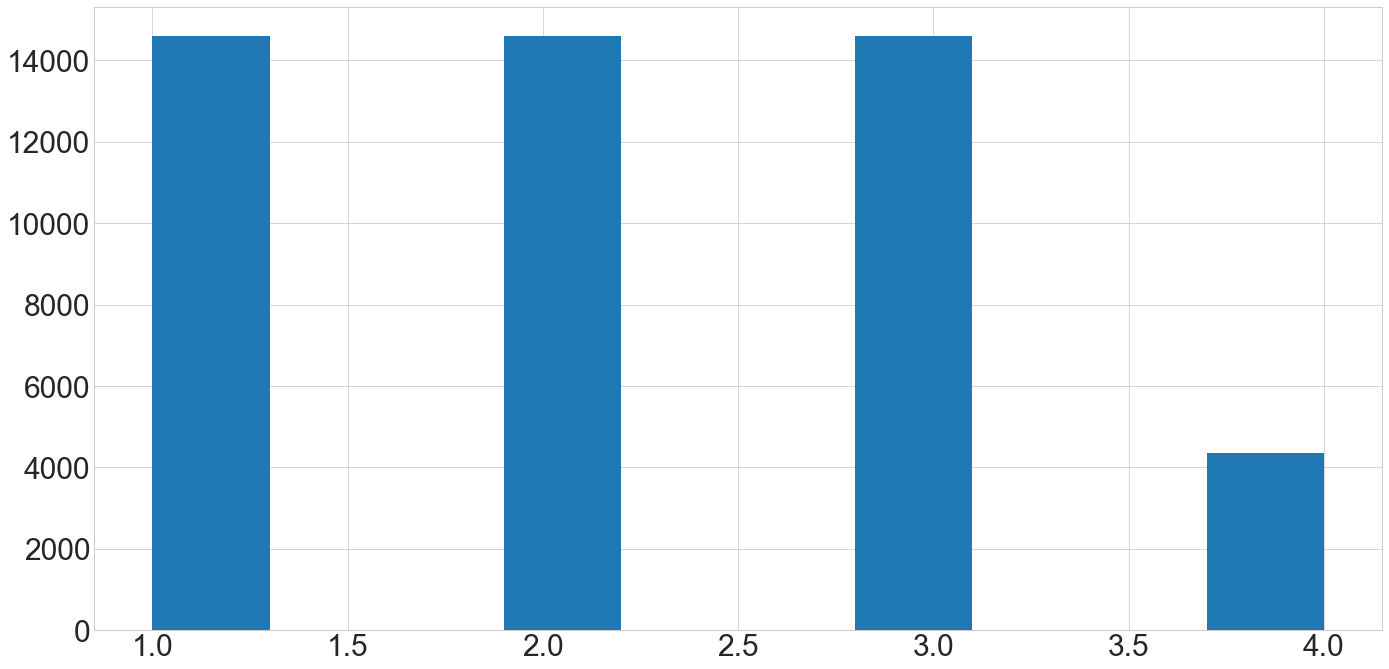

In [7]:
_ = plt.hist(df['Junction'])

We have 4 junctions. They need to be simulated separately.

For now we focus on junction Nr.1.

In [10]:
J1 = df[df['Junction'] == 1]
J1.shape

(14592, 4)

In [11]:
J1['DateTimeInd'] = pd.to_datetime(J1['DateTime'])
J1.pop('DateTime')
J1 = J1.set_index('DateTimeInd')
J1 = J1['Vehicles']
J1

G:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


DateTimeInd
2015-11-01 00:00:00     15
2015-11-01 01:00:00     13
2015-11-01 02:00:00     10
2015-11-01 03:00:00      7
2015-11-01 04:00:00      9
                      ... 
2017-06-30 19:00:00    105
2017-06-30 20:00:00     96
2017-06-30 21:00:00     90
2017-06-30 22:00:00     84
2017-06-30 23:00:00     78
Name: Vehicles, Length: 14592, dtype: int64

14592 entries. A fairly large timeseries.

Now let's take a look at the traffic data.

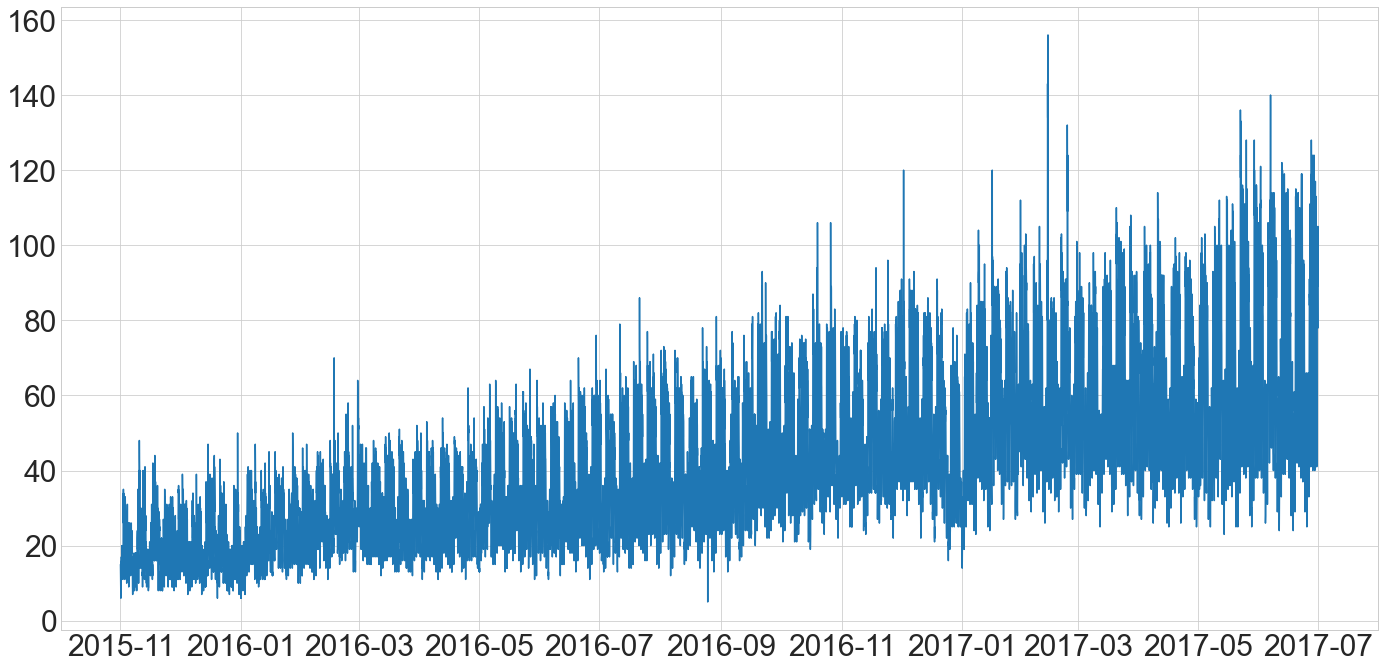

In [12]:
plt.plot(J1)

It looks really coarse. 

Take a look at its fine structure.

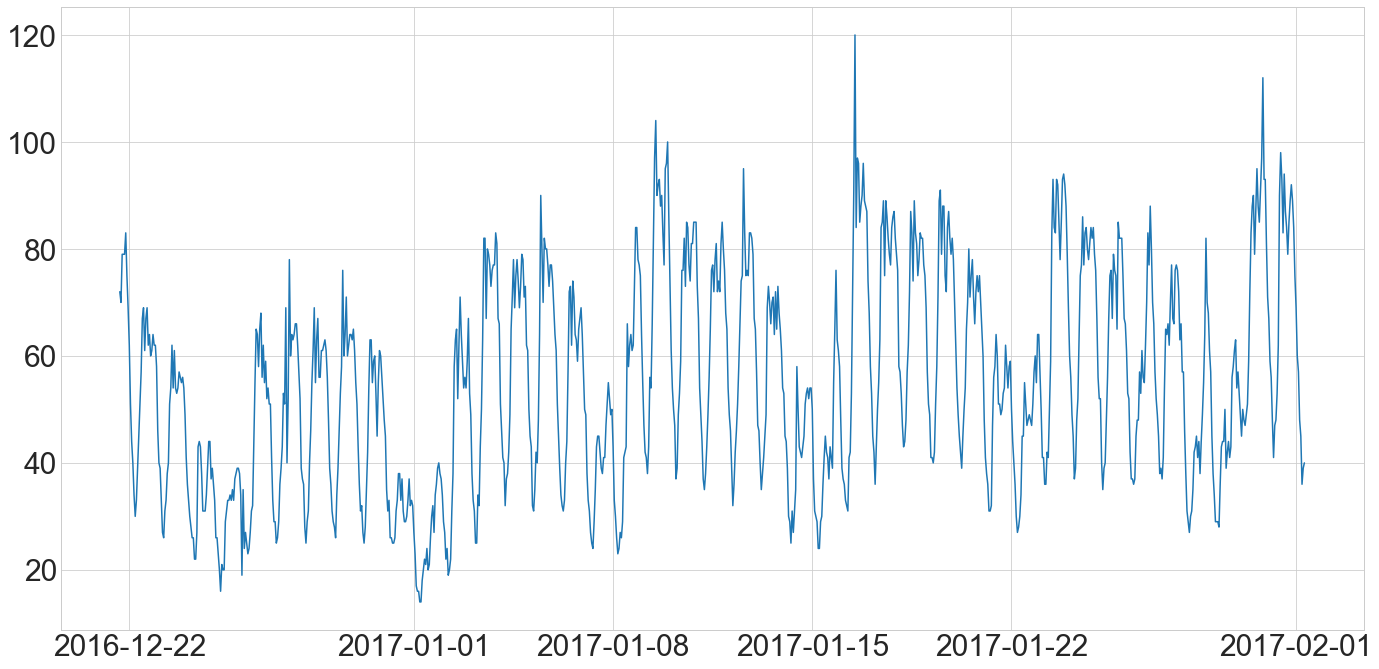

In [15]:
plt.plot(J1[10000:11000])

There are obvious periodic fluctuations. The periods include at least days and weeks.

A nearly linear trend is also observable behind the periodic behaviour.

Let's analyse the periodic behaviour.

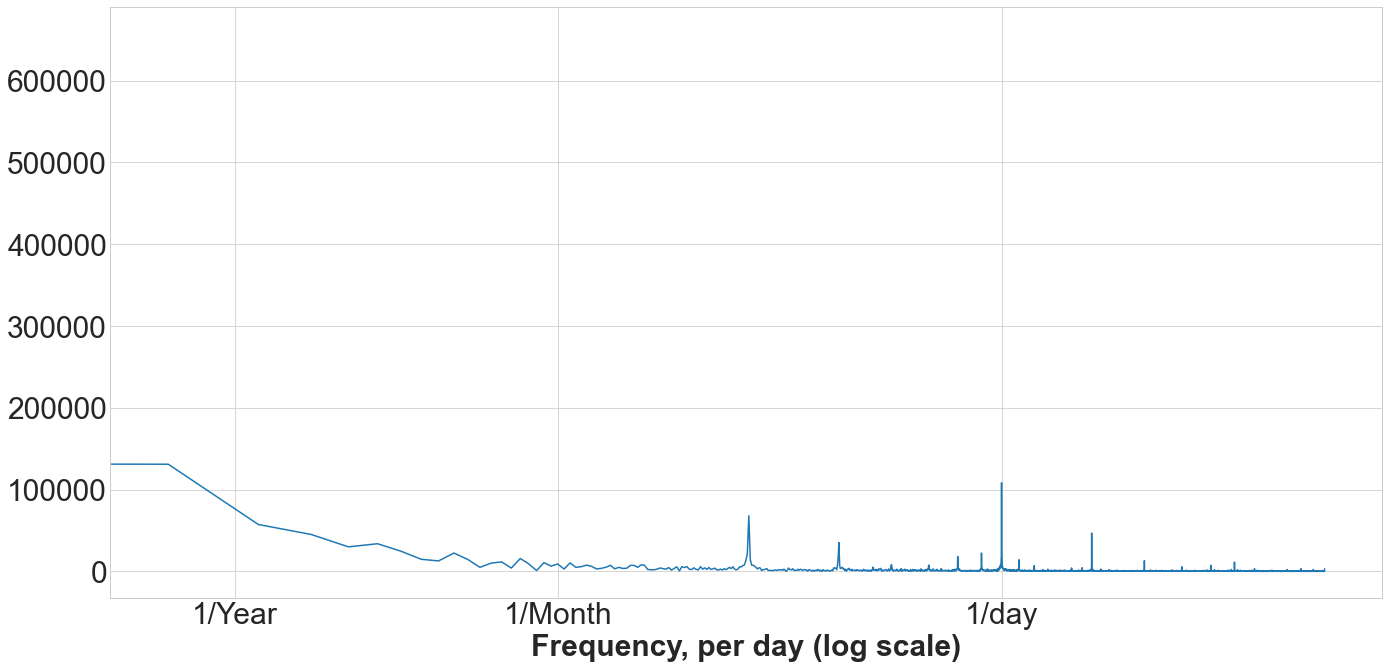

In [20]:
import tensorflow as tf
import numpy as np

J1_fft = tf.signal.rfft(J1)

total_hrs = len(J1)
days_per_dataset = total_hrs / 24

f_per_day = np.arange(0,len(J1_fft)) / days_per_dataset


plt.plot(f_per_day, np.abs(J1_fft))
plt.xscale('log')
plt.xticks([1/365.2524, 1/30.43, 1], labels=['1/Year', '1/Month', '1/day'])
_ = plt.xlabel('Frequency, per day (log scale)')

It's very interesting that the traffic shows a biweekly periodic behavour. 

This becomes more visible if we use the seasonal_decompose tool in the statsmodel toolbox.

(We will split the data at point 13000. Those before this point go into training set, and those after into test set)

In [21]:
train = J1[:13000]
valid = J1[13000:]

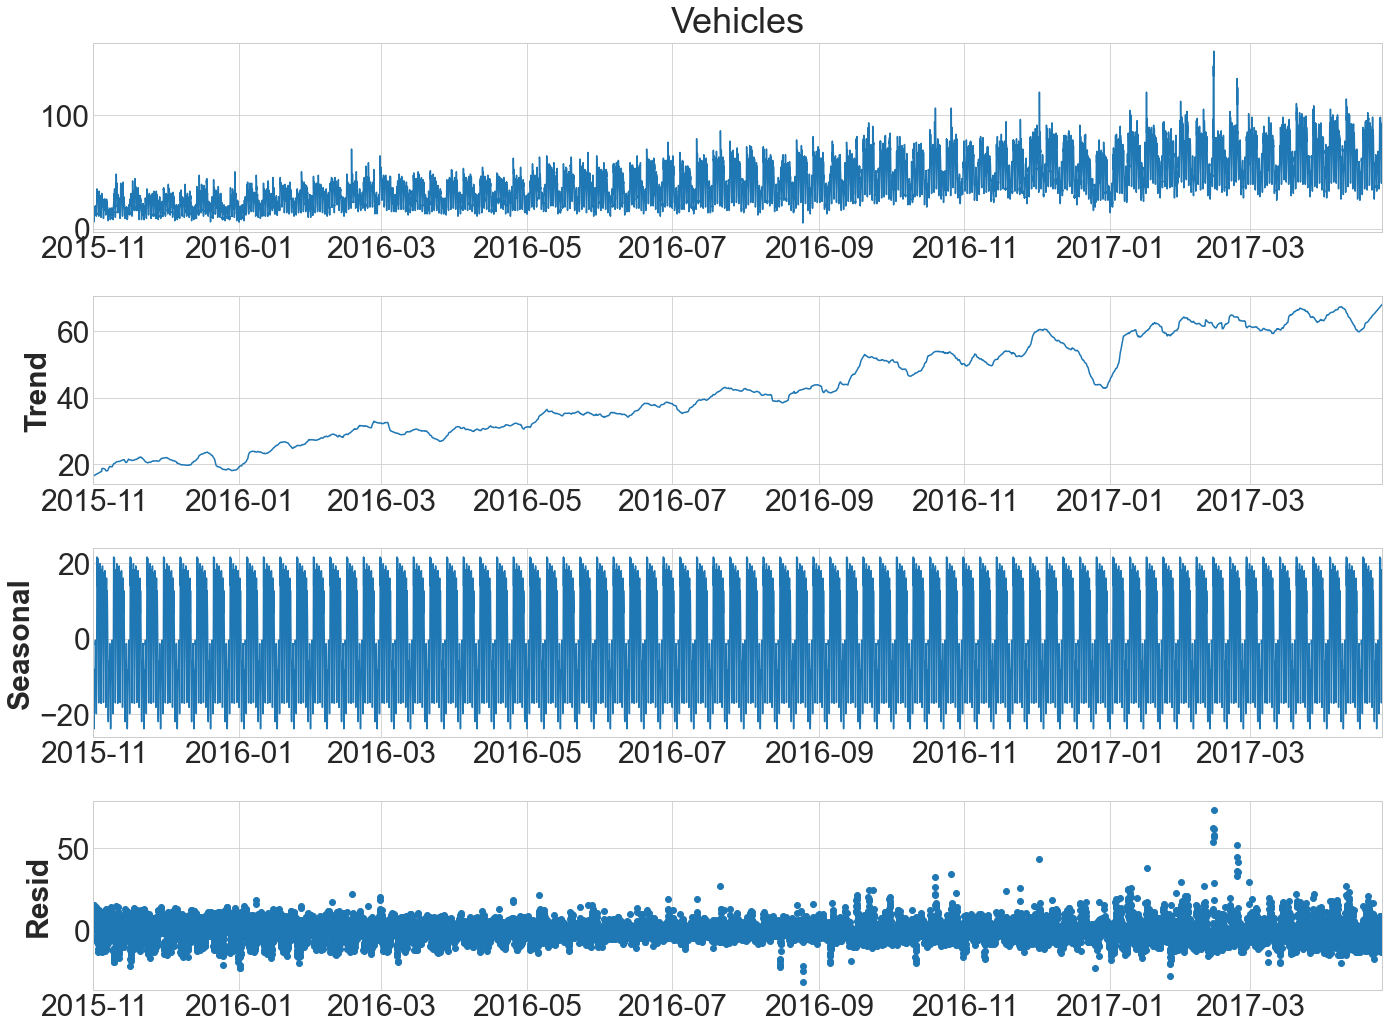

In [24]:
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

decomp = sm.tsa.seasonal_decompose(train, period = 7*24, extrapolate_trend='freq',model='additive')
_ = decomp.plot()

Let's define our baseline of performance prediction.

Since both linear trend and periodic behaviour are present, either using the mean of whole training set or use the last observed value would not be reasonable.
We use the mean of the last 800 points instead.

In [42]:
from sklearn.metrics import mean_absolute_error

average_800 = np.mean(train[-800:])
average_800

63.93375

We will use the first 800 points of the valid set for score calculation.

In [45]:
average_800_pred = np.zeros((800)) + average_800
average_800_mae = mean_absolute_error(average_800_pred, valid[:800])
average_800_mae

20.546928125000004

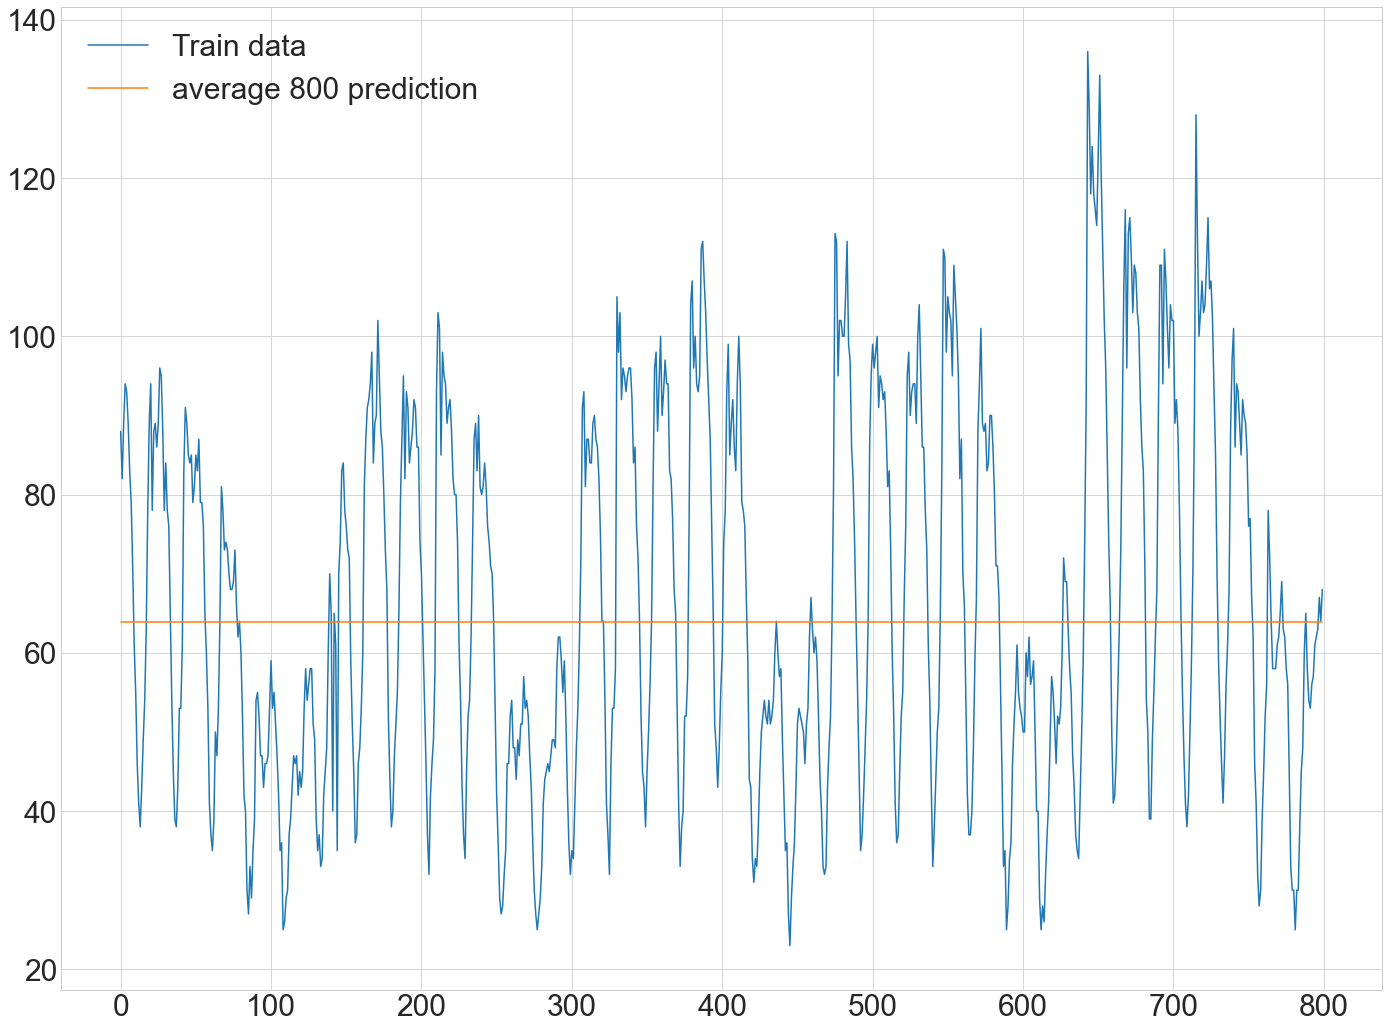

In [48]:
fig, ax = plt.subplots(1)

ax.plot(np.array(valid[:800]), label='Train data')
ax.plot(average_800_pred, label = 'average 800 prediction')
ax.legend()

Now we build a new dataframe for the results of different prediction methods

In [229]:
res_df = pd.DataFrame(columns = ['Method', 'Valid MAE'])

res_df = res_df.append({'Method': 'Mean of last 800 points', 'Valid MAE': average_800_mae}, ignore_index=True)

We shall begin with statistical prediction tools. So naturally we should look into the statistical behaviour as a first step.

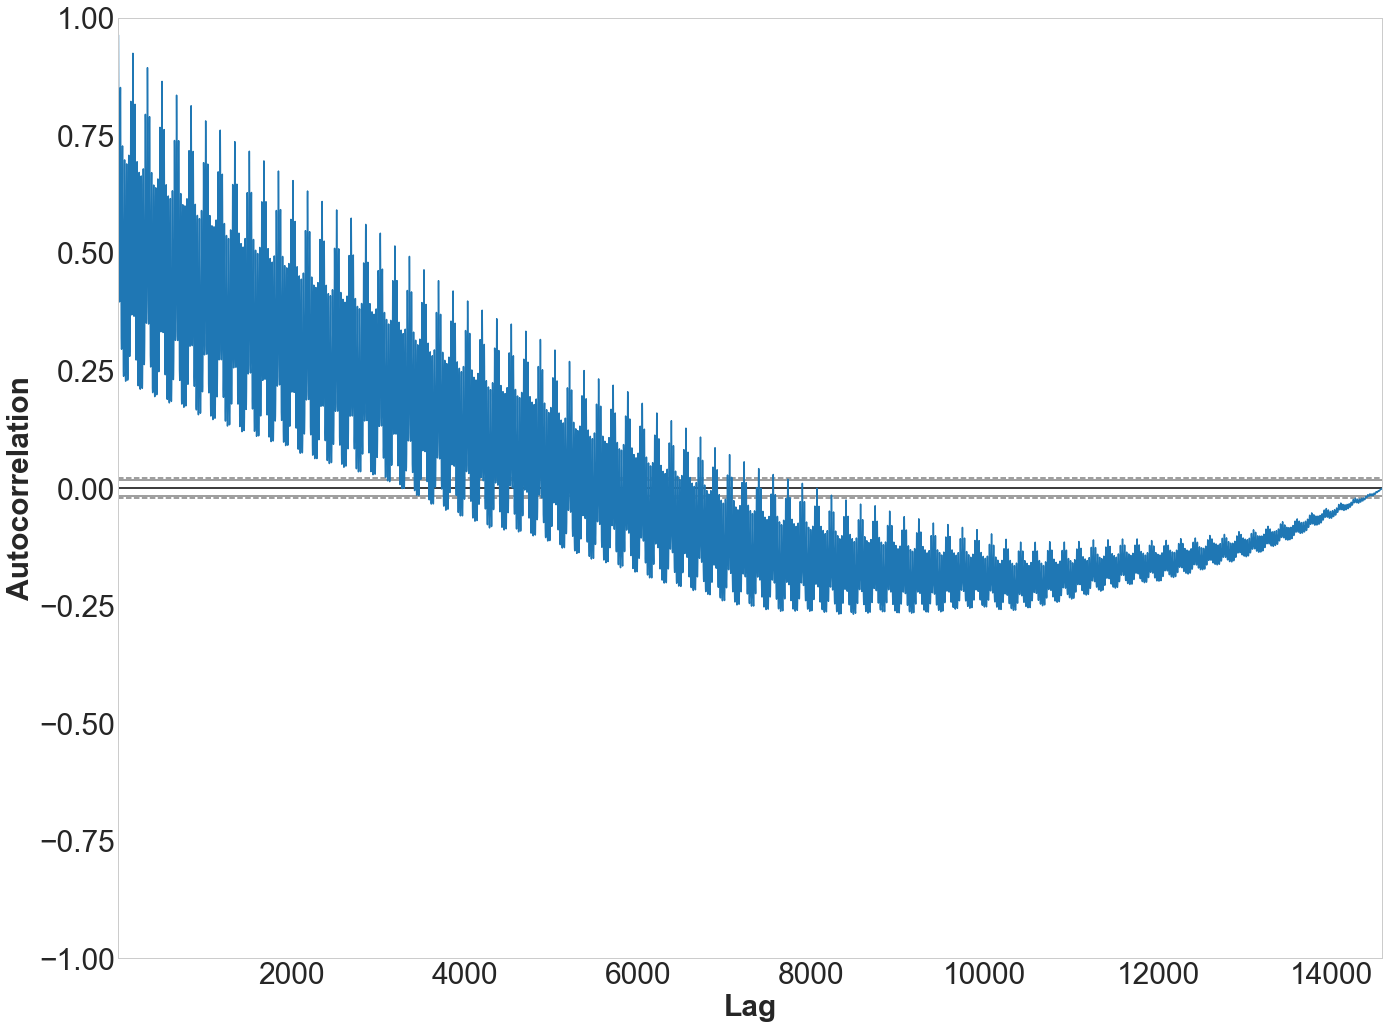

In [25]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(J1)

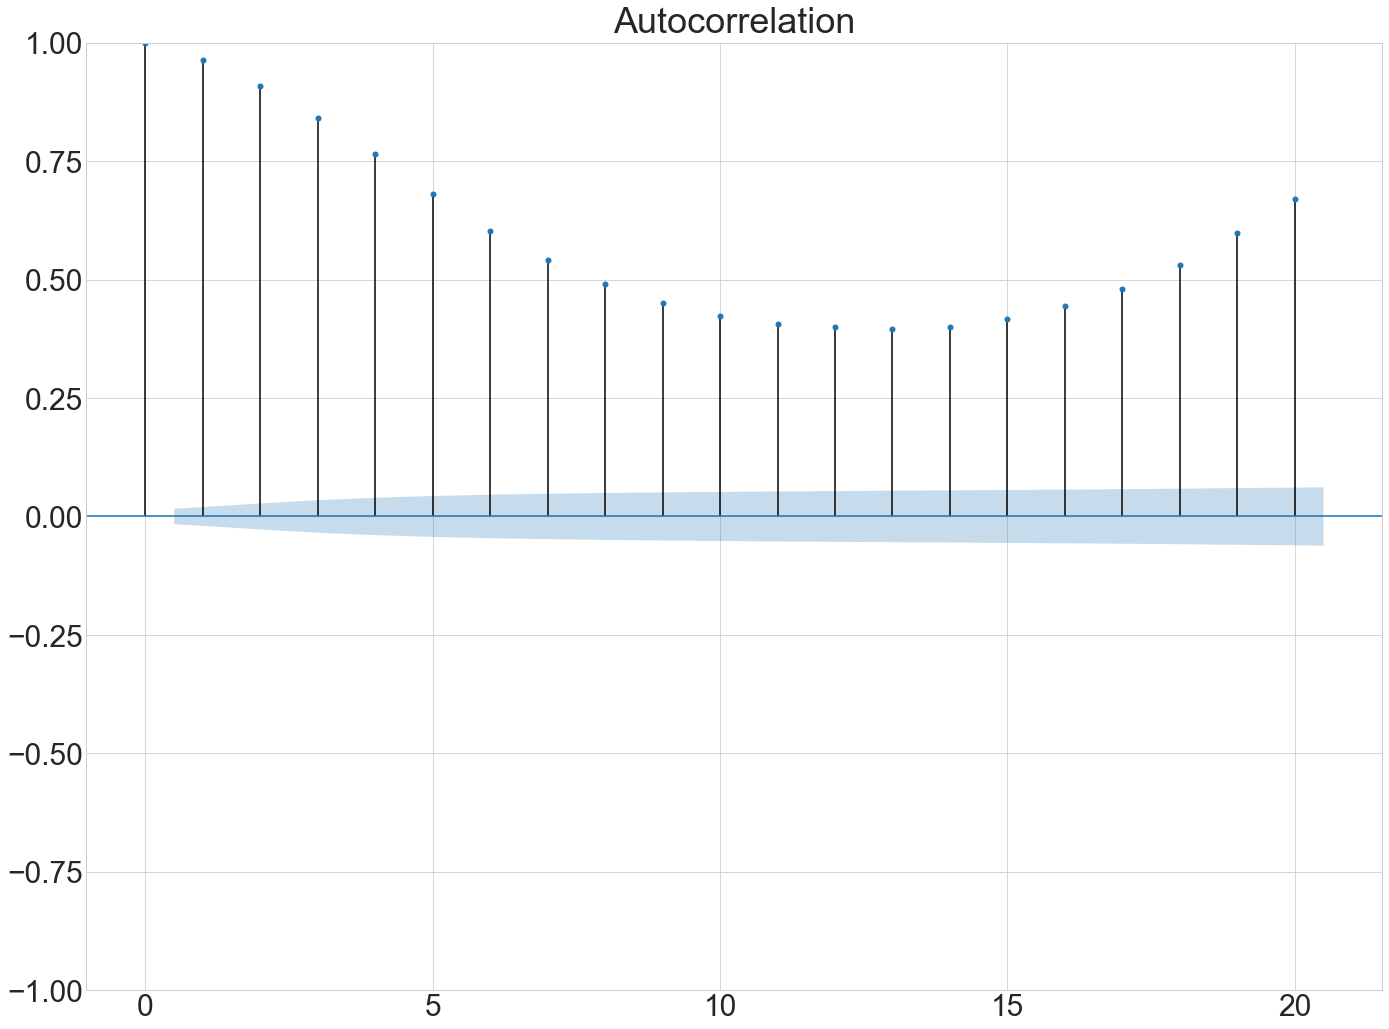

In [26]:
from statsmodels.graphics.tsaplots import plot_acf
fig = plot_acf(J1, lags=20)

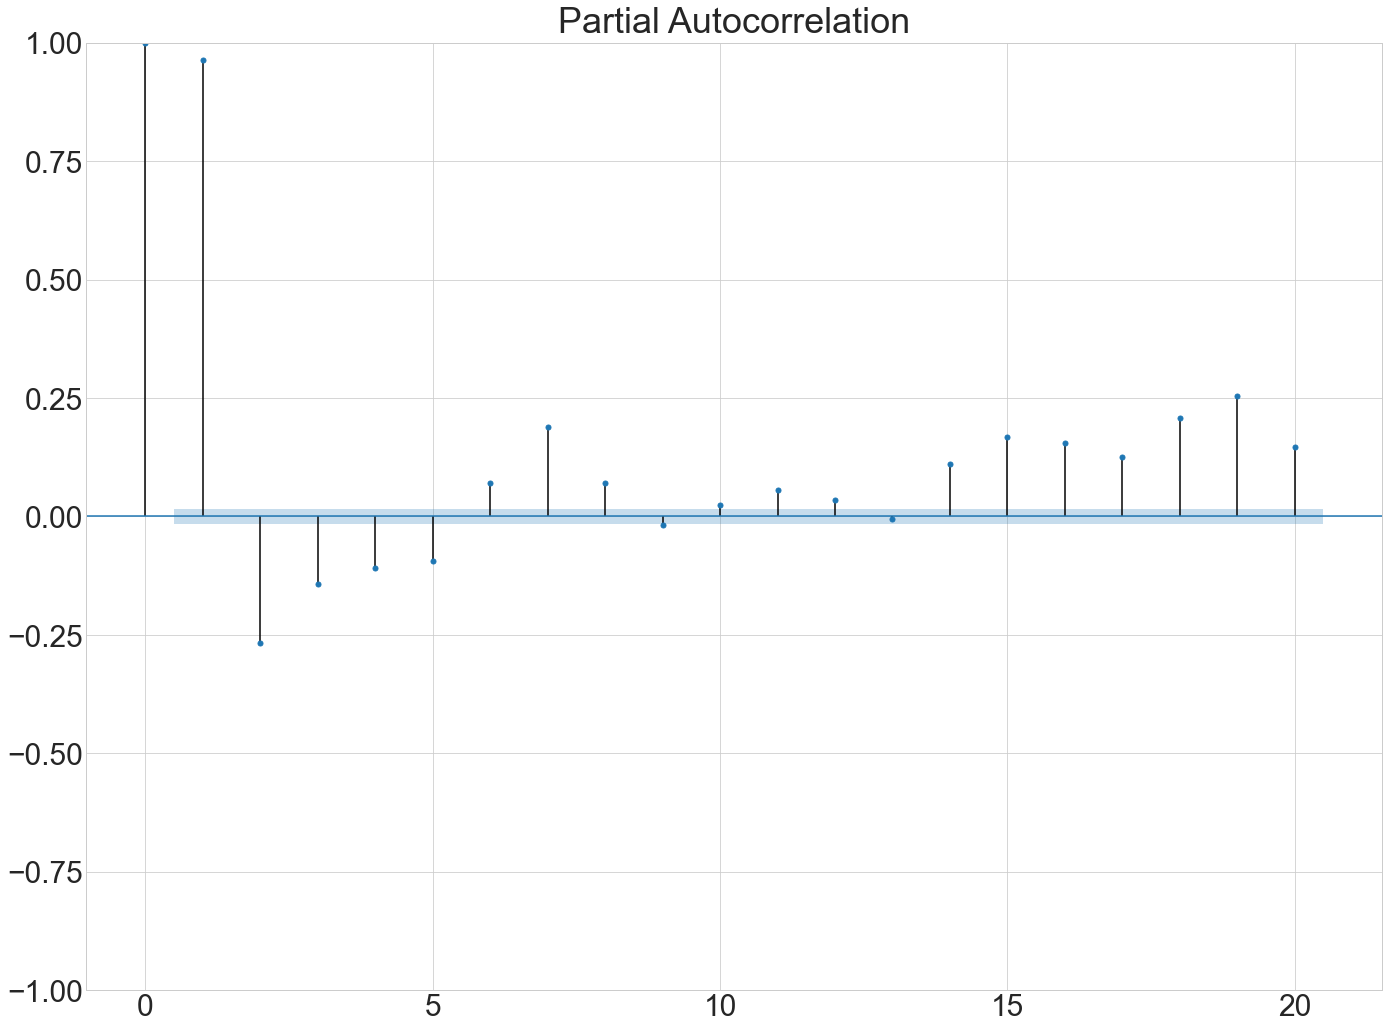

In [27]:
from statsmodels.graphics.tsaplots import plot_pacf
fig = plot_pacf(J1, lags=20)

The dataset has a strong self correlation. ARIMA should be useful here.

The STL forecast is used to deal with seasonal fluctuations.

trend ct is used to deal with linear baseline.

As for the parameters, since the data has a long tail in ACF but short tail in the PACF, a model with large P but small Q should work.

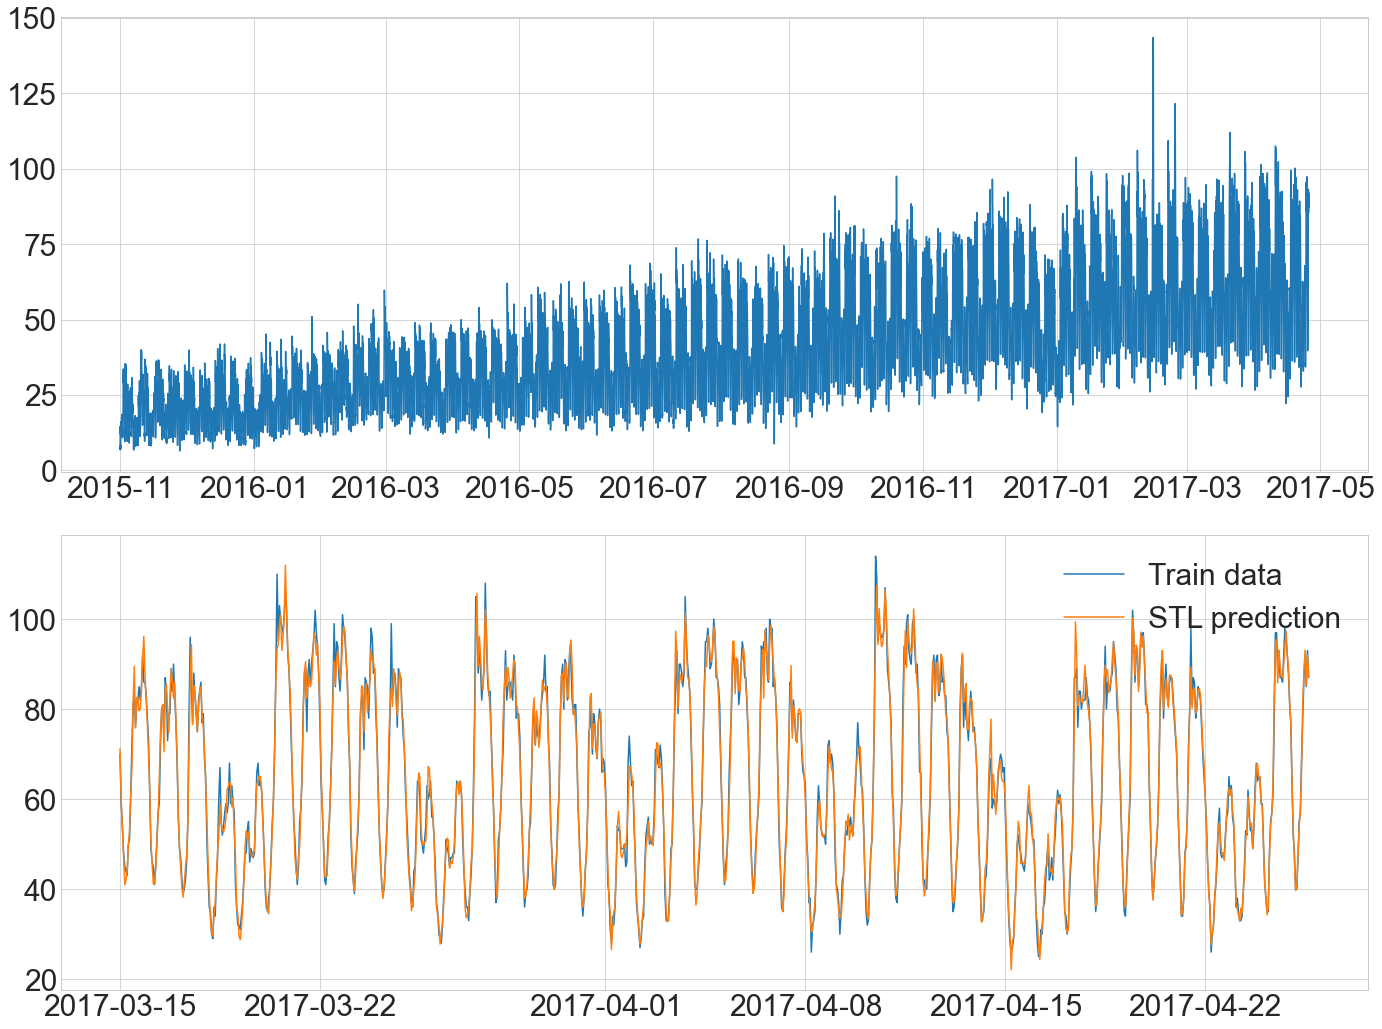

In [30]:
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA

stlf = STLForecast(train, ARIMA, period=24*7, model_kwargs={"order": (3, 0, 1), "trend":"ct"})
res = stlf.fit()
fit_STL_1 = res.get_prediction()# Run time ~ 10 sec on my computer with 4710HQ CPU and 740M GPU

fig, axs = plt.subplots(2)
axs[0].plot(fit_STL_1.predicted_mean)  
axs[1].plot(train[12000:], label='Train data')
axs[1].plot(fit_STL_1.predicted_mean[12000:], label = 'STL prediction')
axs[1].legend()

It does resemble the original dataset.

Let's take a look into the validation results.

A dynamic validation is used. In other words, the prediction at time t+1 is from the prediction (not raw data) at time t.

We predict 800 datapoints after the end of the train dataset (from point 13000 to point 13800)

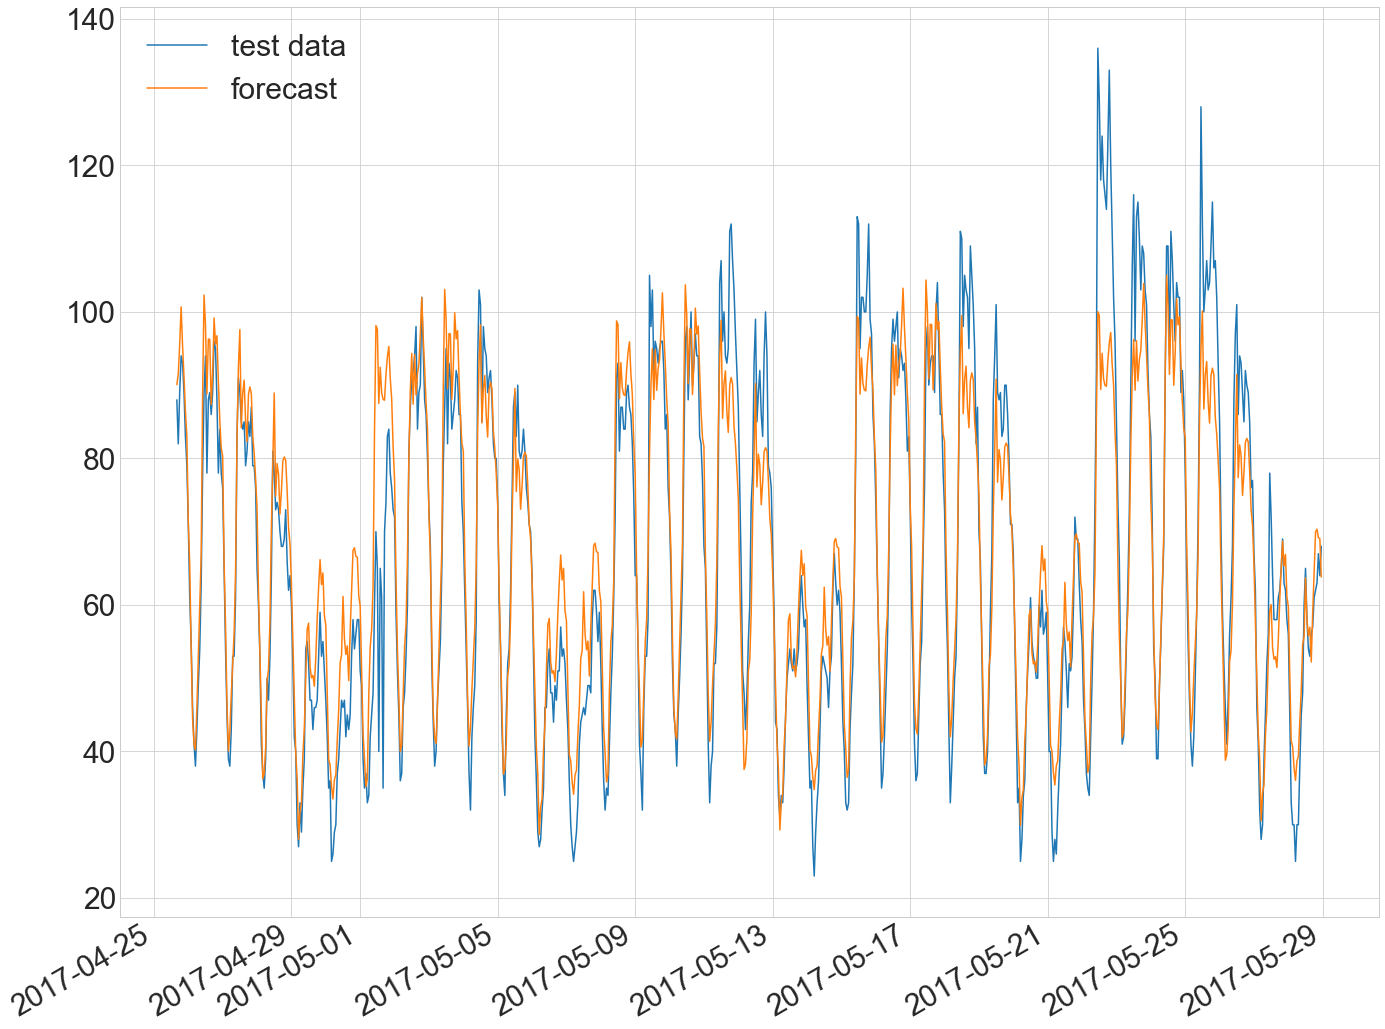

In [228]:
fit_STL_ext = res.get_prediction(end = len(train)+len(valid)-1, dynamic=len(train)) # needs -1 here
fig, ax = plt.subplots(1) 
ax.plot(valid[:800], label='test data')
ax.plot(fit_STL_ext.predicted_mean[13000:13800], label='forecast')

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.legend()

Looks not bad (considering this is 800 hours into the future)

Lets calculate the MAE loss and save the results

In [49]:
STL_mae = mean_absolute_error(fit_STL_ext.predicted_mean[13000:13800],valid[:800])
STL_mae

6.495164815527646

In [230]:
res_df = res_df.append({'Method': 'STL ARIMA 301', 'Valid MAE': STL_mae}, ignore_index=True)
res_df

Method  Valid MAE
0  Mean of last 800 points  20.546928
1            STL ARIMA 301   6.495165

Now let's try neuron networks.

First we need a function for data preparation.

This function will cut time series data into [train_array], [train_label] arrays according to our desired time window width.

In [54]:
import tensorflow as tf

def generate_train_set(train, train_width = 24*7, pred_width = 1):

    train_array = tf.cast(np.array(train), dtype=tf.float32)

    train_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        train_array, None, sequence_length=train_width+pred_width, batch_size = 15000)
    for batch in train_ds:
        train_tensor_bounded = batch

        break
    
    train_tensor = train_tensor_bounded[:,0:train_width]

    train_label = train_tensor_bounded[:, train_width:train_width+pred_width]
    
    return train_tensor, train_label



Next we need a function for dynamic validation.

It takes a warm-up array taken from the end of the train array to make the first prediction. Then the new prediction will be fed to the NN to make the next prediction.

In [150]:
def dynamic_validation(model, valid_label, warm_up_array):
    
    width = len(warm_up_array)
    
    ret = np.zeros(len(valid_label)+width)
    ret[:width] = warm_up_array

    for i in range(len(valid_label)):
        valid_current = ret[i:i+width]
        valid_res_current = model.predict(valid_current.reshape(-1,width))
        ret[i+width] = valid_res_current
    return ret[width:] #drop the warm up array

The third function wraps the things we need to do to get the prediction and forcast together.

In [199]:
def fit_and_forecast(train_tensor, train_label, valid_label, model, warm_up_array, model_str = ''):

    history_obj = model.fit(
        train_tensor, train_label,
        batch_size = 128,
        epochs = 800,
        verbose = 0,

    )

    history_df = pd.DataFrame(history_obj.history)

    fig, axs = plt.subplots(2,2) 
    axs[0,0].plot(history_df.loc[:, ['loss']], label='train_loss')
    axs[0,0].legend()

    model_predicted = model.predict(train_tensor)
    axs[0,1].plot(np.array(train_label[:]), label = 'train data')
    axs[0,1].plot(model_predicted[:], label = model_str + ' prediction')
    axs[0,1].legend()

    axs[1,0].plot(np.array(train_label[-200:]), label = 'train data')
    axs[1,0].plot(model_predicted[-200:], label = model_str + ' prediction')
    axs[1,0].legend()

    #warm_up_array = train_label[-24*7*3:].reshape(-1)
    valid_label_short = np.array(valid_label[:810])

    model_forecast = dynamic_validation(model, valid_label_short, warm_up_array)
    axs[1,1].plot(np.array(valid_label[:800]), label = 'valid data')
    axs[1,1].plot(model_forecast[:800], label = model_str + ' forecast')
    axs[1,1].legend()
    
    return model_forecast


Now let's prepare the training set for feeding the neural networks.

We will use a time window of 3 days and a 3-layer simple NN on the raw test data.

In [152]:
train_tensor_3days, train_label_3days = generate_train_set(train, 24*7*3, 1)

In [161]:
warm_up_array = train[-24*7*3:]
valid_array = np.array(valid)

In [158]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

model_3L_NN = tf.keras.Sequential([
    layers.Dense(128, activation='relu',),
    
    layers.Dense(64, activation = 'relu'),

    layers.Dense(16, activation = 'relu'),
    
    layers.Dense(1)
])

# run time: ca. 20 sec

model_3L_NN.compile(
    optimizer = 'adam',
    loss = 'mae'
)

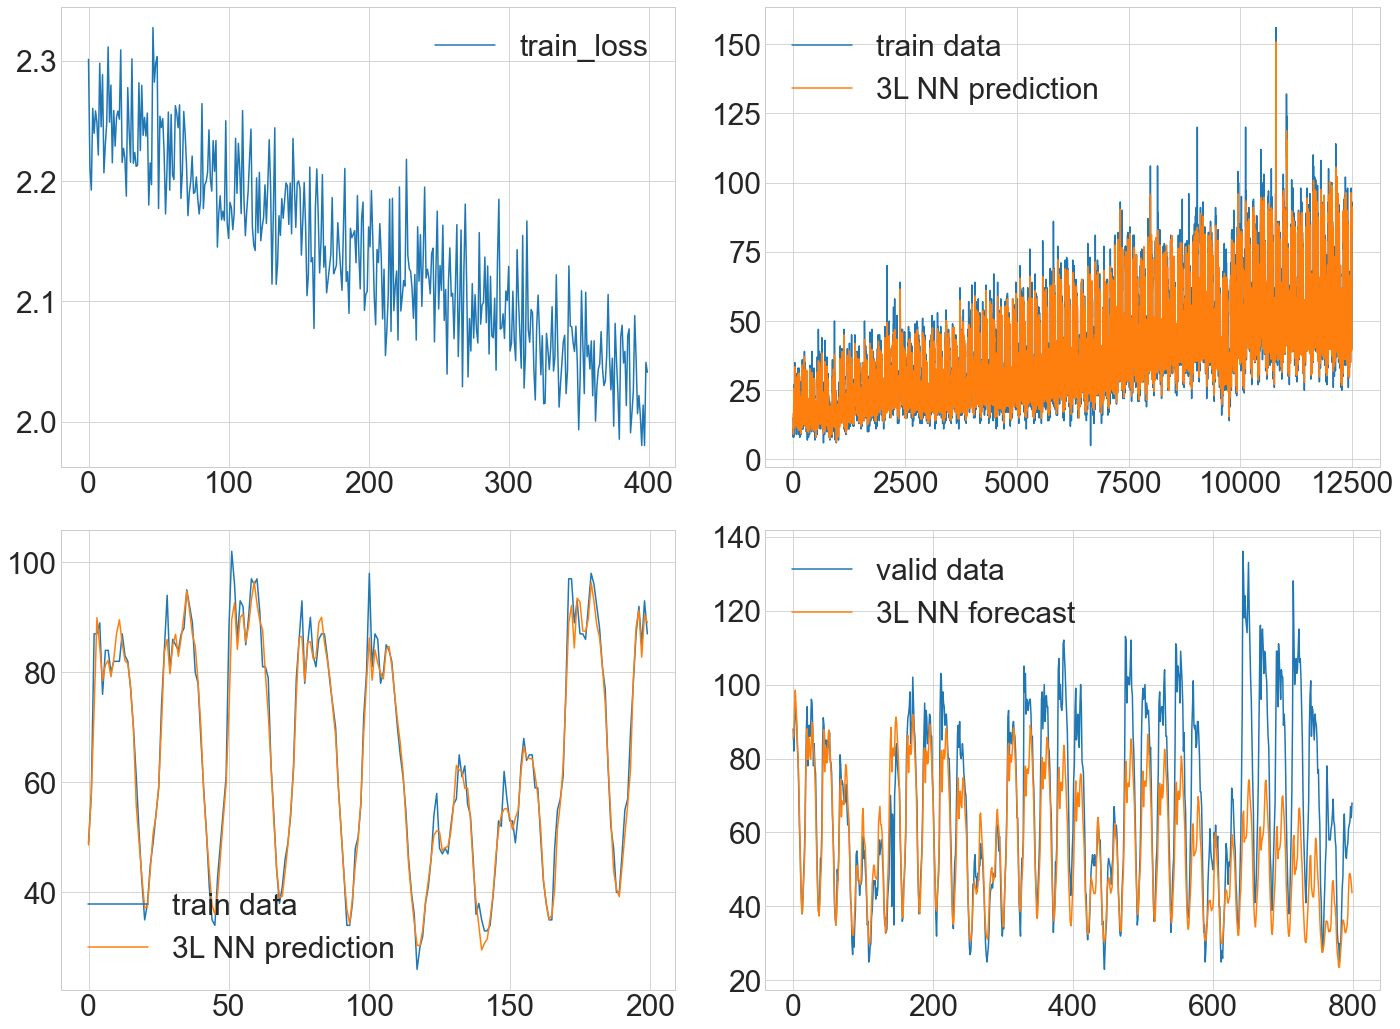

In [162]:
model_3L_NN_forecast = fit_and_forecast(
    train_tensor_3days, 
    train_label_3days, 
    valid_array, 
    model_3L_NN, 
    warm_up_array=warm_up_array,
    model_str = '3L NN')

In [202]:
NN_3L_mae = mean_absolute_error(model_3L_NN_forecast[:800], valid_array[:800])
NN_3L_mae

12.42719846725464

In [231]:
res_df = res_df.append({'Method': '3L NN raw data', 'Valid MAE': NN_3L_mae}, ignore_index=True)
res_df

Method  Valid MAE
0  Mean of last 800 points  20.546928
1            STL ARIMA 301   6.495165
2           3L NN raw data  12.427198

This simple model works quite well in the short term (mae in the first 400 points is only 6.735).

But not so good at longer time.

We observe that the linear trend is not completely fitted.

Let's try manually removing this linear trend before feeding the data to NN.

In [207]:
from sklearn.linear_model import LinearRegression
linear_baseline_model = LinearRegression()

train_array = np.array(train)

X = np.arange(len(train_array))

linear_baseline_model.fit(X.reshape(-1,1), train_array)

baseline = linear_baseline_model.predict(X.reshape(-1,1))

train_array_flat = train_array - baseline

In [208]:
X_valid = np.arange(len(valid_array))
baseline_valid = linear_baseline_model.predict((X_valid+len(X)).reshape(-1,1))

valid_array_flat = valid_array-baseline_valid

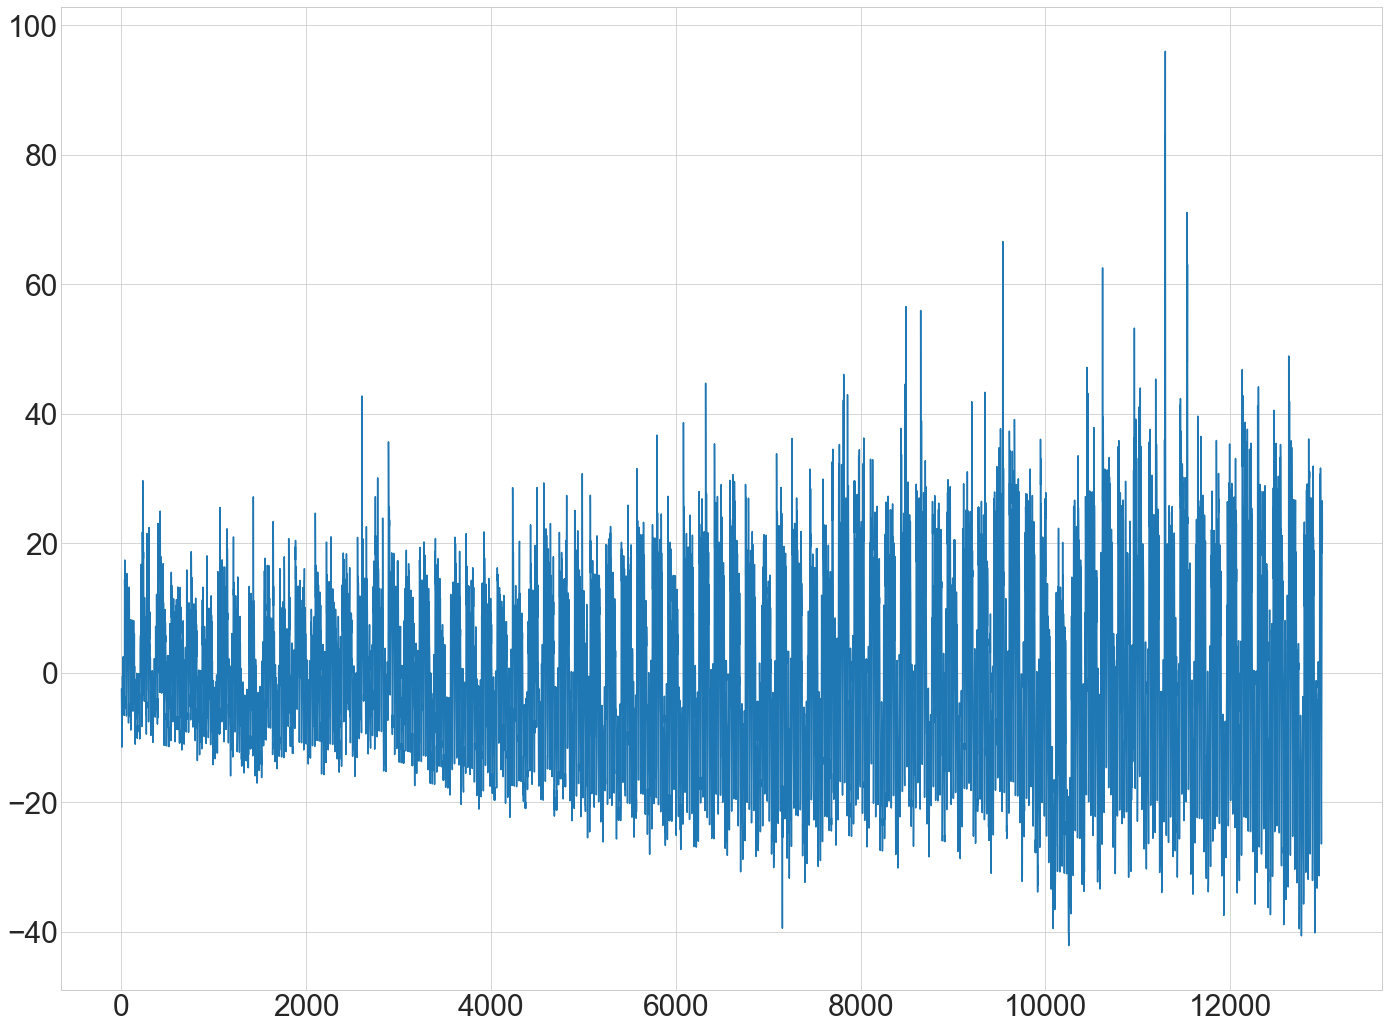

In [167]:
plt.plot(train_array_flat)

In [209]:
train_tensor_3days_flat, train_label_3days_flat = generate_train_set(train_array_flat, 24*7*3, 1)

warm_up_array_flat = train_array_flat[-24*3*7:]

In [212]:
model_3L_NN_flat = tf.keras.Sequential([
    layers.Dense(128, activation='relu',),
    
    layers.Dense(64, activation = 'relu'),

    layers.Dense(16, activation = 'relu'),
    
    layers.Dense(1)
])

# run time: ca. 20 sec

model_3L_NN_flat.compile(
    optimizer = 'adam',
    loss = 'mae'
)

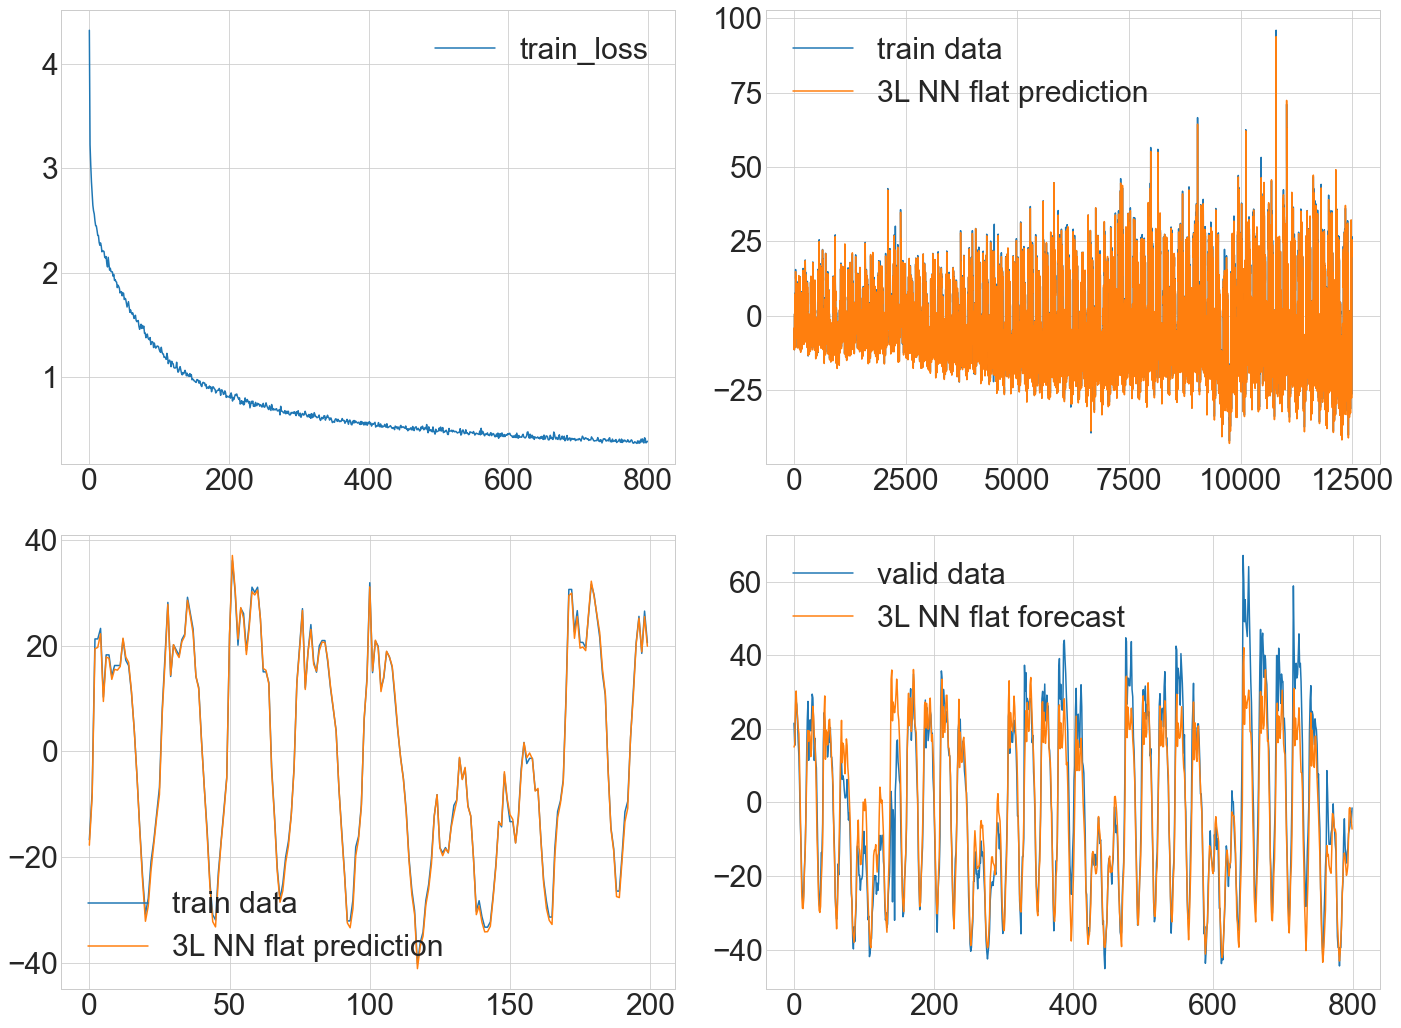

In [213]:
model_3L_NN_flat_forecast = fit_and_forecast(
    train_tensor_3days_flat, 
    train_label_3days_flat, 
    valid_array_flat, 
    model_3L_NN_flat, 
    warm_up_array=warm_up_array_flat,
    model_str = '3L NN flat')

In [232]:
NN_3L_flat_mae = mean_absolute_error(model_3L_NN_flat_forecast[:800], valid_array_flat[:800])
NN_3L_flat_mae

6.0713174776968115

In [233]:
res_df = res_df.append({'Method': '3L NN flattened data', 'Valid MAE': NN_3L_flat_mae}, ignore_index=True)
res_df

Method  Valid MAE
0  Mean of last 800 points  20.546928
1            STL ARIMA 301   6.495165
2           3L NN raw data  12.427198
3     3L NN flattened data   6.071317

How about we change the first layer into LSTM?

In [210]:
model_3L_LSTM_flat = tf.keras.Sequential([
    layers.Reshape((1,24*7*3)),
    layers.LSTM(128, ),
    layers.Dense(64, activation = 'relu'),

    layers.Dense(16, activation = 'relu'),
    
    layers.Dense(1)
])

# run time: ca. 20 sec

model_3L_LSTM_flat.compile(
    optimizer = 'adam',
    loss = 'mae'
)

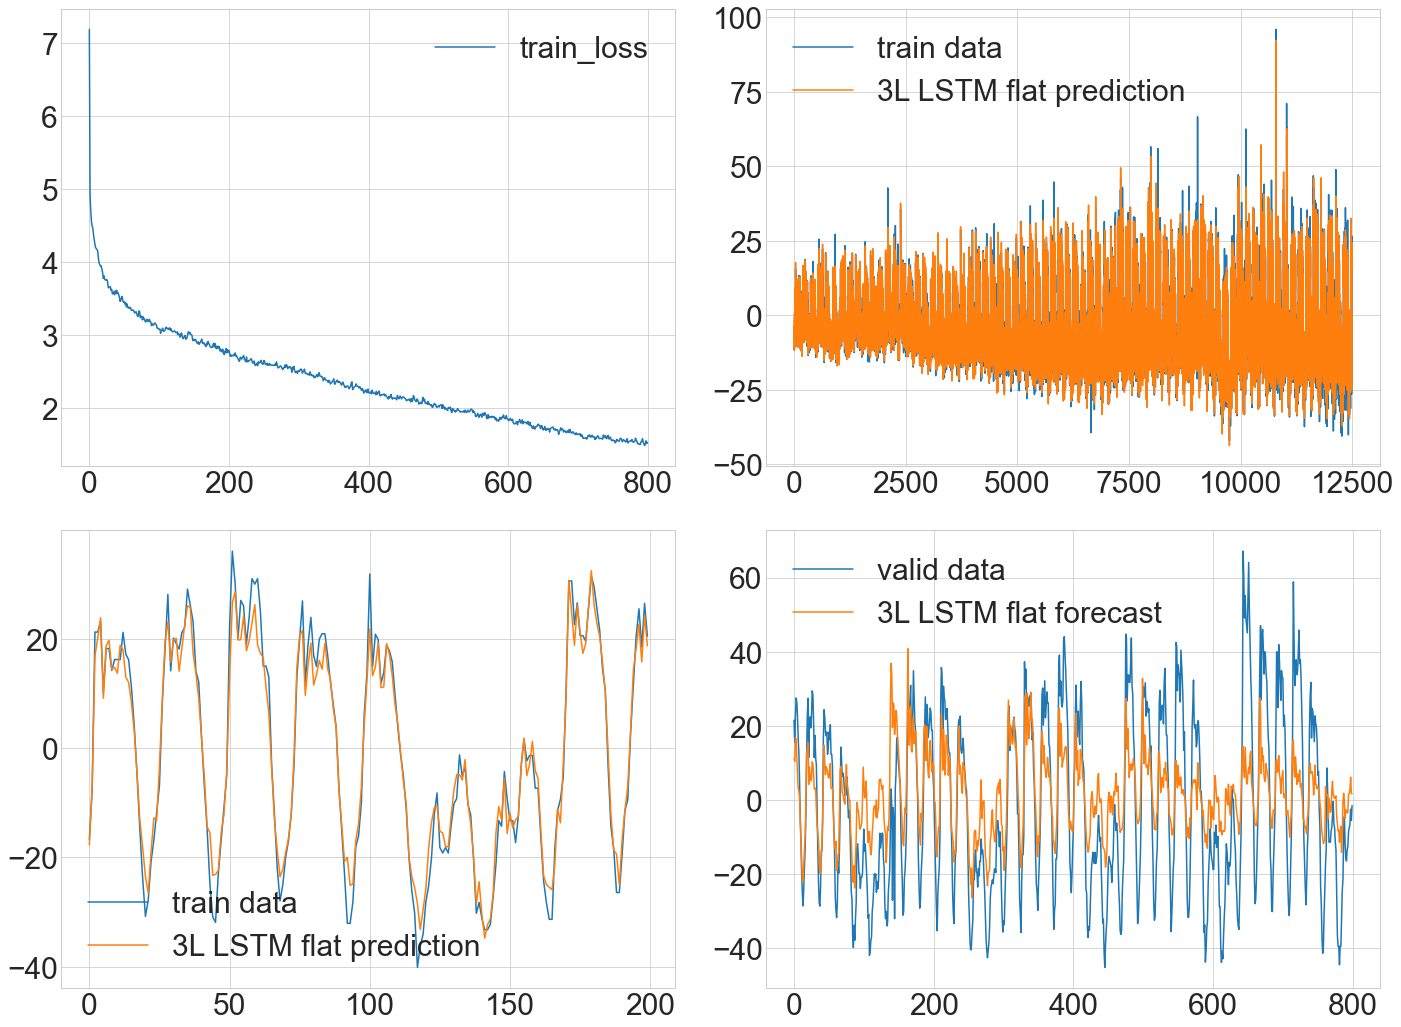

In [211]:
model_3L_LSTM_flat_forecast = fit_and_forecast(
    train_tensor_3days_flat, 
    train_label_3days_flat, 
    valid_array_flat, 
    model_3L_LSTM_flat, 
    warm_up_array=warm_up_array_flat,
    model_str = '3L LSTM flat')

In [218]:
LSTM_3L_flat_mae = mean_absolute_error(model_3L_LSTM_flat_forecast[:800], valid_label[:800])
LSTM_3L_flat_mae

14.17545965864804

In [234]:
res_df = res_df.append({'Method': '3L LSTM', 'Valid MAE': LSTM_3L_flat_mae}, ignore_index=True)
res_df

Method  Valid MAE
0  Mean of last 800 points  20.546928
1            STL ARIMA 301   6.495165
2           3L NN raw data  12.427198
3     3L NN flattened data   6.071317
4                  3L LSTM  14.175460

Our models are still under-representing. Let's try deeper networks.

In [215]:
model_6L_NN_flat = tf.keras.Sequential([
    layers.Dense(256, activation = 'relu'),
    layers.Dense(128, activation='relu',),
    #layers.Dropout(0.2),
    layers.Dense(64, activation = 'relu'),
    #layers.Dropout(0.2),
    layers.Dense(32, activation = 'relu'),
    layers.Dense(16, activation = 'relu'),
    #layers.Dropout(0.2),
    layers.Dense(8, activation = 'relu'),
    #layers.Dropout(0.2),
    layers.Dense(1)
])

# run time: ca. 60 sec

opt = keras.optimizers.Adam(learning_rate=0.005)# Faster learning rate. This was 

model_6L_NN_flat.compile(
    optimizer = opt,
    loss = 'mae'
)

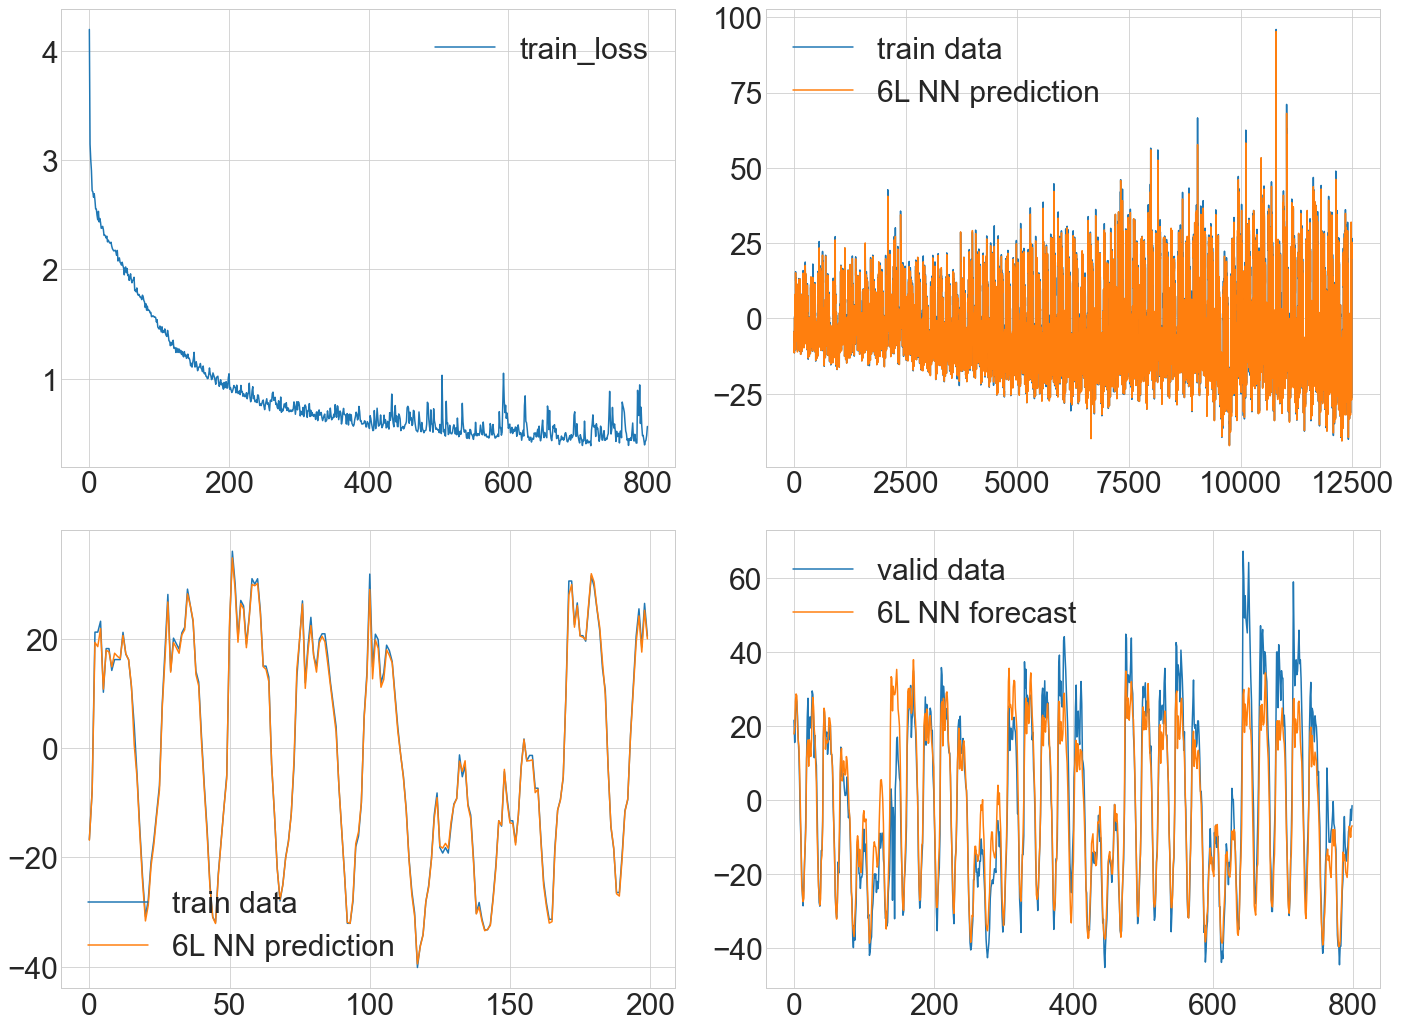

In [216]:
model_6L_NN_flat_forecast = fit_and_forecast(
    train_tensor_3days_flat, 
    train_label_3days_flat, 
    valid_label_flat, 
    model_6L_NN_flat, 
    warm_up_array=warm_up_array_flat,
    model_str = '6L NN')

In [219]:
NN_6L_flat_mae = mean_absolute_error(model_6L_NN_flat_forecast[:800], valid_label_flat[:800])
NN_6L_flat_mae

6.197466772287812

In [235]:
res_df = res_df.append({'Method': '6L NN', 'Valid MAE': NN_6L_flat_mae}, ignore_index=True)
res_df

Method  Valid MAE
0  Mean of last 800 points  20.546928
1            STL ARIMA 301   6.495165
2           3L NN raw data  12.427198
3     3L NN flattened data   6.071317
4                  3L LSTM  14.175460
5                    6L NN   6.197467

In [224]:
model_6L_LSTM_flat = tf.keras.Sequential([
    layers.Reshape((1,24*7*3)),
    layers.LSTM(128, ),
    layers.Dense(128, activation='relu',),
    #layers.Dropout(0.2),
    layers.Dense(64, activation = 'relu'),
    #layers.Dropout(0.2),
    layers.Dense(32, activation = 'relu'),
    layers.Dense(16, activation = 'relu'),
    #layers.Dropout(0.2),
    layers.Dense(8, activation = 'relu'),
    #layers.Dropout(0.2),
    layers.Dense(1)
])

# run time: ca. 60 sec

opt = keras.optimizers.Adam(learning_rate=0.01)# Faster learning rate. This was 

model_6L_LSTM_flat.compile(
    optimizer = opt,
    loss = 'mae'
)

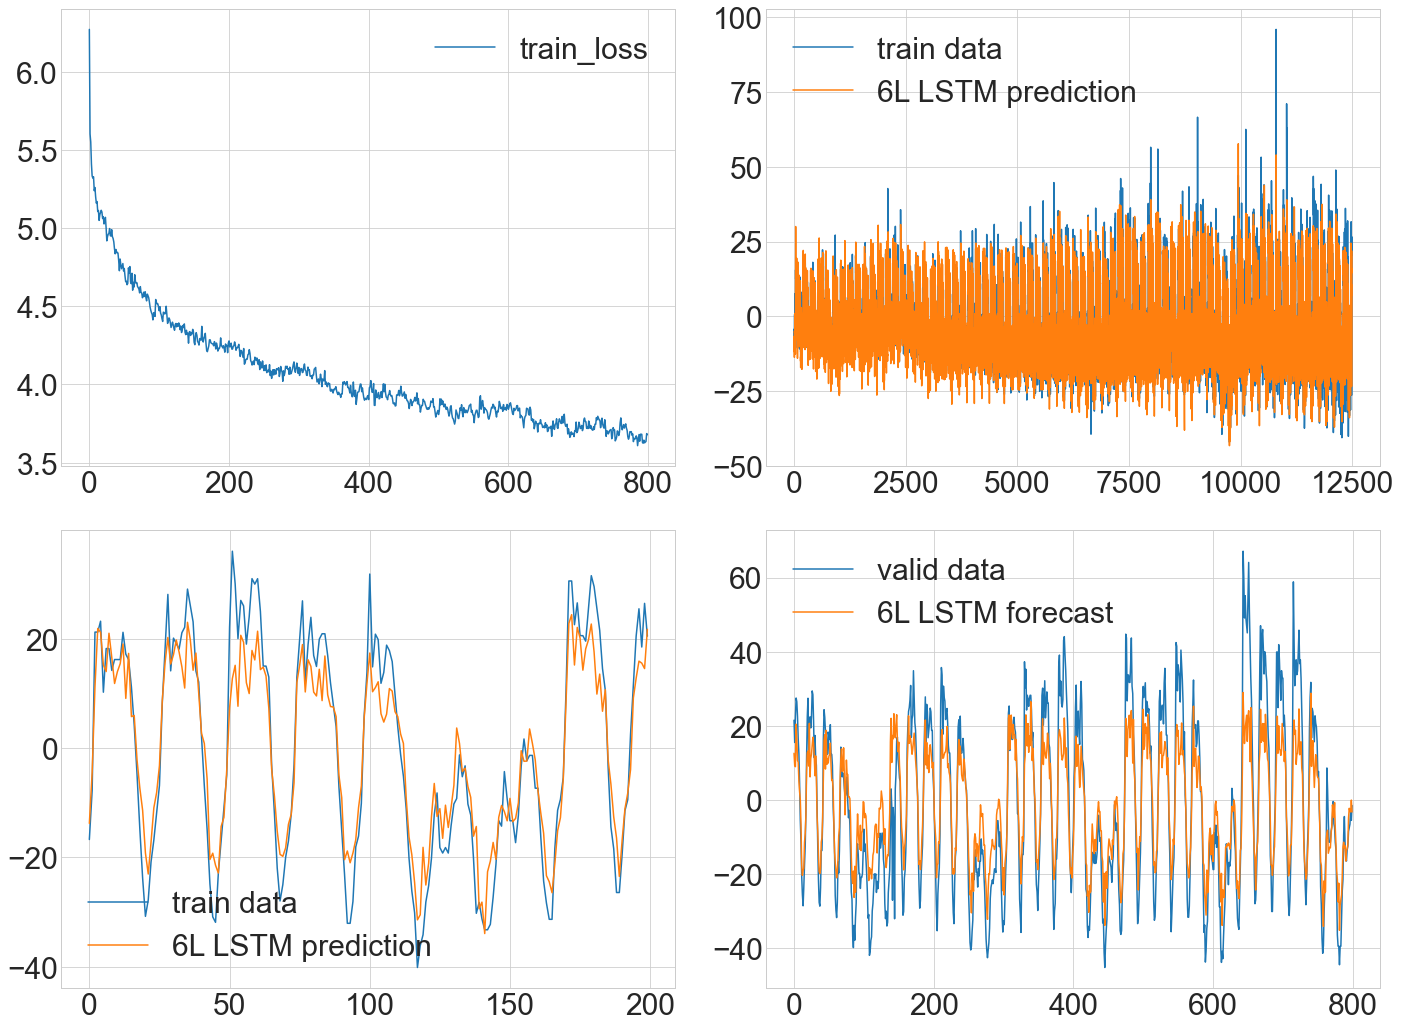

In [225]:
model_6L_LSTM_forecast = fit_and_forecast(
    train_tensor_3days_flat, 
    train_label_3days_flat, 
    valid_label_flat, 
    model_6L_LSTM_flat, 
    warm_up_array=warm_up_array_flat,
    model_str = '6L LSTM')

In [226]:
LSTM_6L_mae = mean_absolute_error(model_6L_LSTM_forecast[:800], valid_label_flat[:800])
LSTM_6L_mae

9.073193477169648

In [236]:
res_df = res_df.append({'Method': '6L LSTM', 'Valid MAE': LSTM_6L_mae}, ignore_index=True)
res_df

Method  Valid MAE
0  Mean of last 800 points  20.546928
1            STL ARIMA 301   6.495165
2           3L NN raw data  12.427198
3     3L NN flattened data   6.071317
4                  3L LSTM  14.175460
5                    6L NN   6.197467
6                  6L LSTM   9.073193

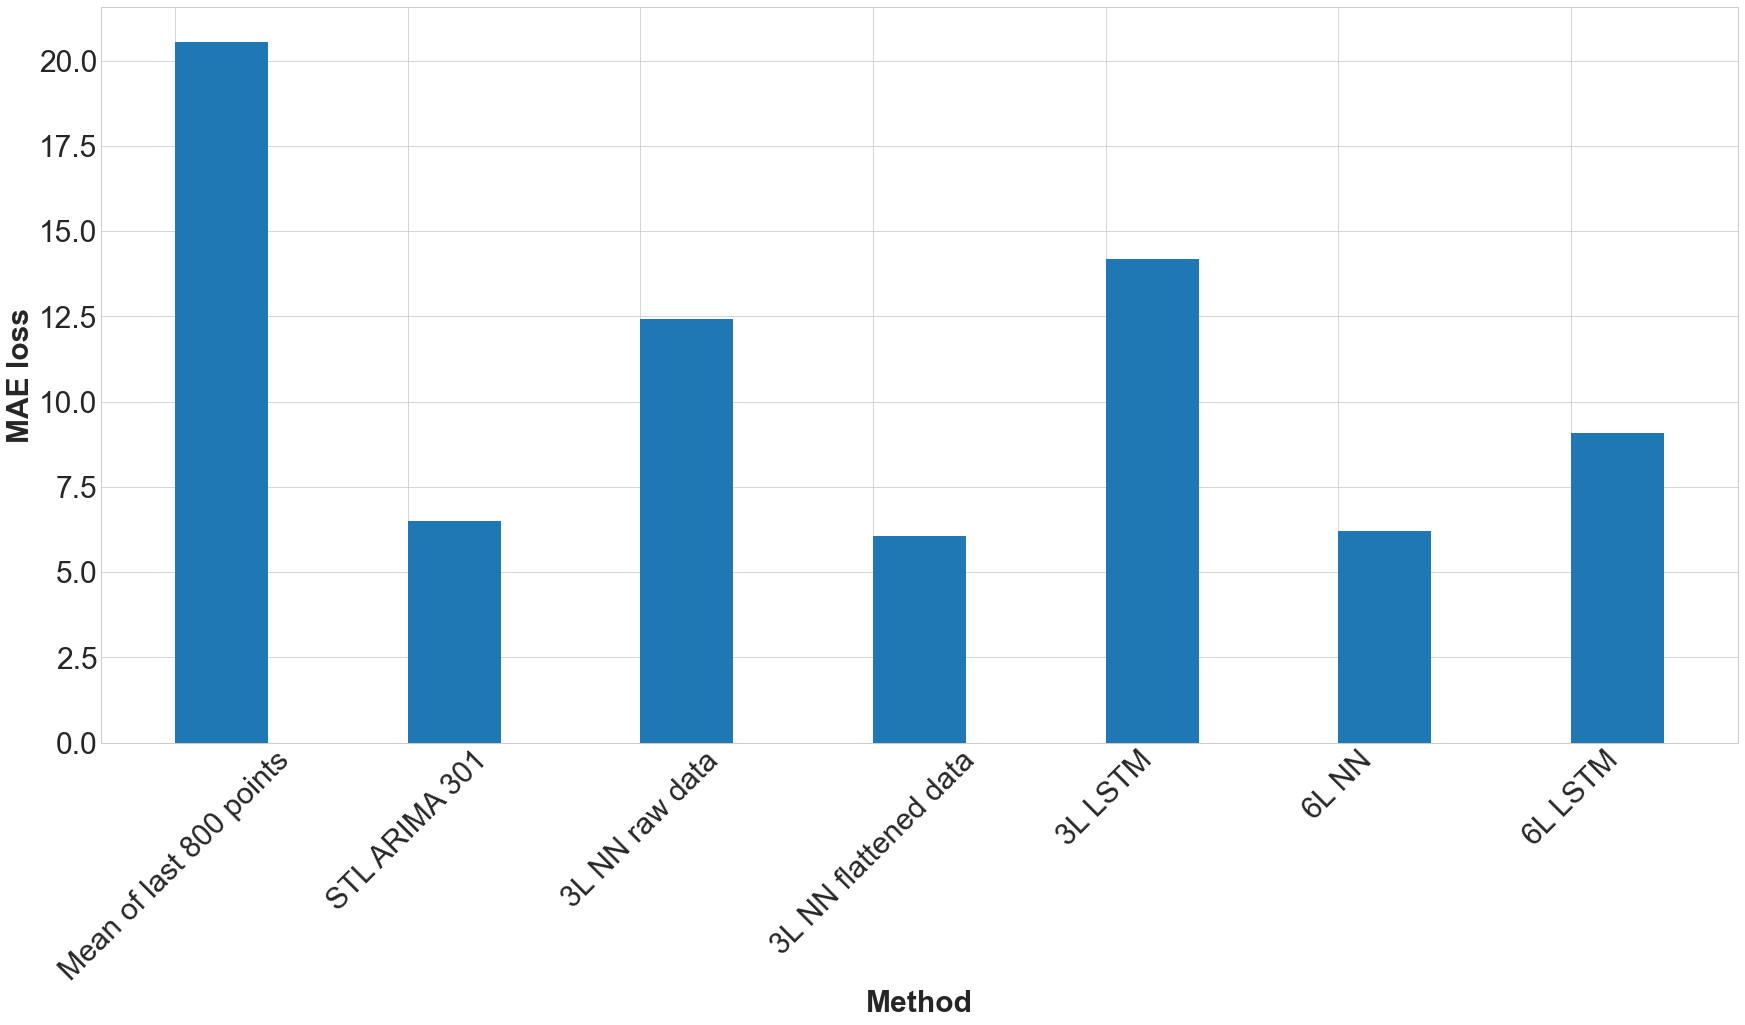

In [237]:
plt.figure(figsize = (25,15))
plt.bar(res_df['Method'], res_df['Valid MAE'],align='edge', width=0.4)
plt.xlabel('Method')
plt.ylabel('MAE loss')

plt.xticks(rotation=45)

plt.rcParams.update({'font.size': 32})

A grid search was not done yet (on the to-do list already) so it's still too early to draw concrete conclusions.

But these points seem apparent:

1. STL is very good for this dataset.

2. 3 layer NN is already quite good. 6 layers does not make it better.

3. LSTM tends to underfit the data.

One possible reason is that the data is governed by the periodic fluctuation which is quite repeatable (thus STL can work quite well). LSTM might "forget" as we push forcast further and further.

To-do:

Tune the network
Tune the epochs and batches (we are still in the underfitting regime)
Tune the learning rate